# Setup

In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from types import SimpleNamespace
from glob import glob
import datetime as dt
from haversine import haversine
from datetime import datetime
from tqdm import tqdm

P = SimpleNamespace()
P.data = "../data"
CRS_DEG = 'EPSG:4326'
CRS_M = 'EPSG:3857'

# Get the evacuation rate

In [7]:
# post_homes = pd.concat([
#     pd.read_parquet(f).assign(date = f.split('\\')[-1].split('.')[0]) # "\\" for windows, "/" for other os
#     for f in tqdm(glob(P.data + '/home_dists/*.parquet'))
# ]).reset_index(drop=True)

# post_homes['date'] = pd.to_datetime(post_homes['date'])

# pre_homes = post_homes[post_homes['date']<= datetime.strptime('2021-08-21', '%Y-%m-%d')].reset_index()

# pre_homes = pre_homes.groupby("uid").agg({"dist_home2home": [np.nanmean, np.nanstd], \
#                              "dist_work2home": [np.nanmean, np.nanstd]})

# pre_homes = pre_homes.reset_index()
# pre_homes.columns = ['_'.join(col).strip() for col in pre_homes.columns.values]

# merged_home = pd.merge(pre_homes, post_homes, left_on='uid_', right_on='uid', how = 'left')

# merged_home['threshold_night'] = merged_home['dist_home2home_nanmean']+2*merged_home['dist_home2home_nanstd']
# merged_home['threshold_day'] = merged_home['dist_work2home_nanmean']+2*merged_home['dist_work2home_nanstd']
# merged_home['threshold_night'] = merged_home['threshold_night'].clip(lower=400/1609.344) # the minimum threshold is 400 m
# merged_home['threshold_day'] = merged_home['threshold_day'].clip(lower=400/1609.344)
# merged_home['displaced_night'] = merged_home['dist_home2home']>merged_home['threshold_night']
# merged_home['displaced_day'] = merged_home['dist_work2home']>merged_home['threshold_day']

# merged_home = merged_home.groupby('uid').agg({'displaced_night': list, 'displaced_day':list, 'date':list}).reset_index()

In [8]:
# merged_home.to_parquet(P.data+ '/displaced_by_halfday.parquet')

In [12]:
def get_displace_status(row, thres1 = 3, thres2 = 8):
    index = [dt.days for dt in (pd.to_datetime(row['date']) - datetime.strptime('2021-08-01', '%Y-%m-%d'))]
    displaced = [-1]*(2*(datetime.strptime('2021-12-01', '%Y-%m-%d') - datetime.strptime('2021-08-01', '%Y-%m-%d')).days)
    for i, disp_night, disp_day in zip(index, row['displaced_night'], row['displaced_day']):
        displaced[i*2] = 1 if disp_day else 0
        displaced[i*2 + 1] = 1 if disp_night else 0 
    
    current_state = 0
    for i in range(len(displaced)-10+1):
        if(1-current_state == displaced[i]): # start of a new state
            count_left = sum([1 if j==1 else 0 for j in displaced[i:(i+10)]])
            count_return = sum([1 if j==0 else 0 for j in displaced[i:(i+10)]])
            if(count_left>=thres1):
                current_state = 1
                for j in range(i+1, i+thres1):
                    displaced[j] = 1
            elif(count_return>=thres2):
                current_state = 0
                for j in range(i+1, i+thres2):
                    displaced[j] = 0
        
        displaced[i] = current_state
            
    for i in range(len(displaced)-10+1, len(displaced)):
        displaced[i] = current_state
    
    return displaced

In [13]:
def find_first(x,inds,target=1):
    for ind in inds:
        if x[ind]==1 and x[ind-1] == 0:
            return ind
    return -1



def find_return_t(row):
    if (row['disp_t']>0):
        for ind in range(row['disp_t'], len(row['disp_status'])):
            if row['disp_status'][ind]==0:
                return ind
    return -1

In [20]:
# # Sensitivity analysis, change the thresholds of evacuation to see how many users are evacuated

# # x = thresholds
# # y = disp by uids lists 

# # store it as a dictionary
# res1 = {}

# for thres1 in range(1, 10):
#       merged_home = pd.read_parquet(P.data+ '/displaced_by_halfday.parquet')
#       merged_home['disp_status'] = merged_home.apply(lambda row: get_displace_status(row, thres1), axis = 1)
#       merged_home['disp_status'] = merged_home['disp_status'].apply(lambda x: np.array(x))
#       merged_home['disp_t'] = -1
#       merged_home['disp_t'] = merged_home['disp_status'].apply(lambda x: find_first(x, list(range(42,244))))
#       merged_home['returned_t'] = merged_home.apply(lambda x: find_return_t(x), axis = 1)
#       merged_home['returned'] = merged_home['returned_t'].apply(lambda x: x>0)
#       merged_home['duration'] = merged_home['returned_t'] - merged_home['disp_t']
#       res1[thres1] = merged_home

# # store the results
# import pickle
# with open(P.data + '/sensitivity_analysis_part1.pkl', 'wb') as f:
#     pickle.dump(res1, f)

In [115]:
with open(P.data + '/sensitivity_analysis_part1.pkl', 'rb') as f:
      res1 = pickle.load(f)

In [118]:
# find users in the study region
pre_homes = pd.read_parquet(P.data + '/Ida_home.parquet')
merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg')

pre_homes = gpd.GeoDataFrame(pre_homes, geometry=gpd.points_from_xy(pre_homes['lon'], pre_homes['lat']), crs=CRS_DEG)

# Perform spatial join with 'within' predicate
pre_homes  = gpd.sjoin(pre_homes, merged_tract[['id', 'geometry']], how='inner', predicate='within')

# x is the thres1, y is the evacuated users
xs = []
ys = []
ys2 = []
for x in range(1, 10):
    evacuated = res1[x].loc[res1[x]['uid'].isin(pre_homes['uid'])]
    ys.append(np.sum((evacuated['disp_t']>=42)&(evacuated['disp_t']<122)))
    ys2.append(np.sum((evacuated['disp_t']>=122)&(evacuated['disp_t']<184)))
    xs.append(x)

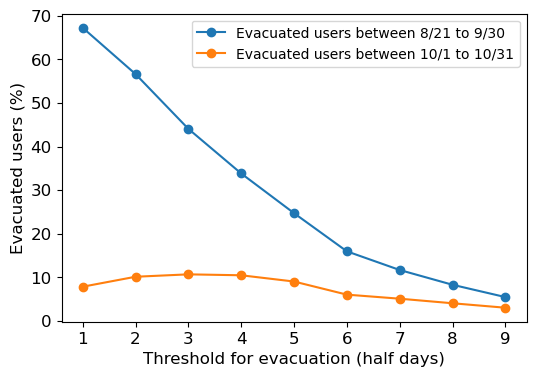

In [119]:
plt.subplots(figsize=(6,4))

plt.plot(xs, np.array(ys)/len(pre_homes)*100, '-o', label = 'Evacuated users between 8/21 to 9/30')
plt.plot(xs, np.array(ys2)/len(pre_homes)*100, '-o', label = 'Evacuated users between 10/1 to 10/31')

plt.xlabel('Threshold for evacuation (half days)', fontsize=12)
plt.ylabel('Evacuated users (%)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend()

plt.savefig( '../figs/sensitivity_analysis_part1.png', dpi=300)
plt.savefig('../figs/sensitivity_analysis_part1.pdf', dpi=300)

In [117]:
# res2 = {}

# for thres2 in range(1, 10):
#       merged_home = pd.read_parquet(P.data+ '/displaced_by_halfday.parquet')
#       merged_home['disp_status'] = merged_home.apply(lambda row: get_displace_status(row, 4, thres2), axis = 1)
#       merged_home['disp_status'] = merged_home['disp_status'].apply(lambda x: np.array(x))
#       merged_home['disp_t'] = -1
#       merged_home['disp_t'] = merged_home['disp_status'].apply(lambda x: find_first(x, list(range(42,244))))
#       merged_home['returned_t'] = merged_home.apply(lambda x: find_return_t(x), axis = 1)
#       merged_home['returned'] = merged_home['returned_t'].apply(lambda x: x>0)
#       merged_home['duration'] = merged_home['returned_t'] - merged_home['disp_t']
#       res2[thres2] = merged_home

# # store the results
# import pickle
# with open(P.data + '/sensitivity_analysis_part2.pkl', 'wb') as f:
#     pickle.dump(res2, f)

In [102]:
with open(P.data + '/sensitivity_analysis_part2.pkl', 'rb') as f:
      res2 = pickle.load(f)

In [113]:
# find users in the study region
pre_homes = pd.read_parquet(P.data + '/Ida_home.parquet')
merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg')

pre_homes = gpd.GeoDataFrame(pre_homes, geometry=gpd.points_from_xy(pre_homes['lon'], pre_homes['lat']), crs=CRS_DEG)

# Perform spatial join with 'within' predicate
pre_homes  = gpd.sjoin(pre_homes, merged_tract[['id', 'geometry']], how='inner', predicate='within')

# x is the thres1, y is the evacuated users
xs = []
ys = []
ys2 = []
for x in range(1, 10):
    evacuated = res2[x].loc[res2[x]['uid'].isin(pre_homes['uid'])]
    ys.append(np.sum((evacuated['disp_t']>=42)&(evacuated['disp_t']<122)&(evacuated['duration']>0))/np.sum((evacuated['disp_t']>=42)&(evacuated['disp_t']<122)))
    ys2.append(np.sum((evacuated['disp_t']>=122)&(evacuated['disp_t']<184)&(evacuated['duration']>0))/np.sum((evacuated['disp_t']>=122)&(evacuated['disp_t']<184)))
    xs.append(x)

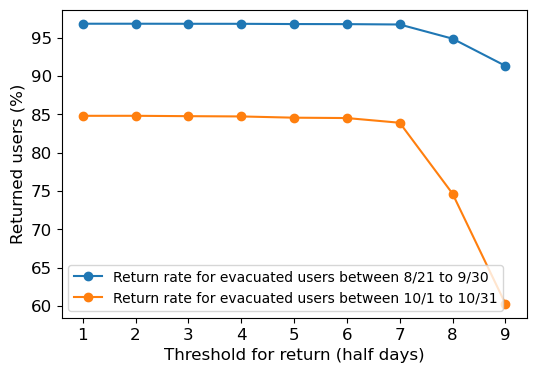

In [114]:
plt.subplots(figsize=(6,4))

plt.plot(xs, np.array(ys)*100, '-o', label = 'Return rate for evacuated users between 8/21 to 9/30')
plt.plot(xs, np.array(ys2)*100, '-o', label = 'Return rate for evacuated users between 10/1 to 10/31')

plt.xlabel('Threshold for return (half days)', fontsize=12)
plt.ylabel('Returned users (%)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend()

plt.savefig('../figs/sensitivity_analysis_part2.png', dpi=300)
plt.savefig('../figs/sensitivity_analysis_part2.pdf', dpi=300)

In [70]:
# we choose thres1 to be 4 and thres2 to be 7
merged_home = pd.read_parquet(P.data+ '/displaced_by_halfday.parquet')

merged_home['disp_status'] = merged_home.apply(lambda row: get_displace_status(row, 4, 7), axis = 1)
merged_home['disp_status'] = merged_home['disp_status'].apply(lambda x: np.array(x))

merged_home['disp_t'] = -1
merged_home['disp_t'] = merged_home['disp_status'].apply(lambda x: find_first(x, list(range(42,244))))

merged_home['returned_t'] = merged_home.apply(lambda x: find_return_t(x), axis = 1)
merged_home['returned'] = merged_home['returned_t'].apply(lambda x: x>0)
merged_home['duration'] = merged_home['returned_t'] - merged_home['disp_t']

merged_home.to_parquet(P.data+"/disp_by_uid.parquet")

# Start at here!










































In [71]:
pre_homes = pd.read_parquet(P.data + '/Ida_home.parquet')
merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg')

pre_homes = gpd.GeoDataFrame(pre_homes, geometry=gpd.points_from_xy(pre_homes['lon'], pre_homes['lat']), crs=CRS_DEG)

# Perform spatial join with 'within' predicate
pre_homes  = gpd.sjoin(pre_homes, merged_tract[['id', 'geometry']], how='inner', predicate='within')

In [72]:
merged_home = pd.read_parquet(P.data + "/disp_by_uid.parquet")
merged_home = pd.merge(merged_home, pre_homes[['uid', 'id']], on = 'uid')
sample_size = len(merged_home)
sample_size

283708

In [73]:
merged_home = merged_home[merged_home['disp_t']>=42]

In [74]:
len(merged_home[merged_home['returned_t']>0])/len(merged_home)

0.9141373947708505

In [75]:
len(merged_home)

136963

In [76]:
len(merged_home)/sample_size

0.48276044383662076

Plot a bar plot for combining displacement and return.

In [77]:
merged_home_return = merged_home.groupby("returned_t")['uid'].count().reset_index()
merged_home_disp = merged_home.groupby("disp_t")['uid'].count().reset_index()
merged_home_return_disp = pd.merge(merged_home_return, merged_home_disp, left_on = 'returned_t', right_on = 'disp_t', how = 'outer')
merged_home_return_disp['time_ind'] = merged_home_return_disp.apply(lambda x: x['returned_t'] if np.isnan(x['disp_t']) else x['disp_t'], axis = 1)
merged_home_return_disp = merged_home_return_disp[merged_home_return_disp['time_ind']!=-1]
merged_home_return_disp = merged_home_return_disp.fillna(0)
merged_home_return_disp.columns = ['returned_t', 'return', 'disp_t', 'disp', 'time_ind']
merged_home_return_disp.drop(['returned_t', 'disp_t'], axis = 1, inplace = True)
merged_home_return_disp = merged_home_return_disp.sort_values(by='time_ind').reset_index(drop = True)

In [78]:
# add time_ind with 0 in merged_home_return_disp
for time_ind in range(42, 244):
      if time_ind not in merged_home_return_disp['time_ind'].values:
            merged_home_return_disp = pd.concat([merged_home_return_disp, pd.DataFrame([[0, 0, time_ind]], columns = ['return', 'disp', 'time_ind'])], axis = 0)

merged_home_return_disp = merged_home_return_disp.sort_values(by='time_ind').reset_index(drop = True)

In [79]:
# Use this: /home/umni2/a/umnilab/users/verma99/mk/nsf_rapid_ida/data/geometry/la_acs.gpkg

In [80]:
def merge_array(arr):
    result = []
    for i in range(0, len(arr), 2):
        if i+1 < len(arr):
            result.append(max(arr[i], arr[i+1]))
    return result

In [81]:
merged_home_return_disp

,return,disp,time_ind
0,0.0,857.0,42.0
1,0.0,1330.0,43.0
2,0.0,937.0,44.0
3,0.0,1475.0,45.0
4,131.0,4236.0,46.0
...,...,...,...
197,0.0,0.0,239.0
198,0.0,0.0,240.0
199,0.0,0.0,241.0
200,0.0,0.0,242.0


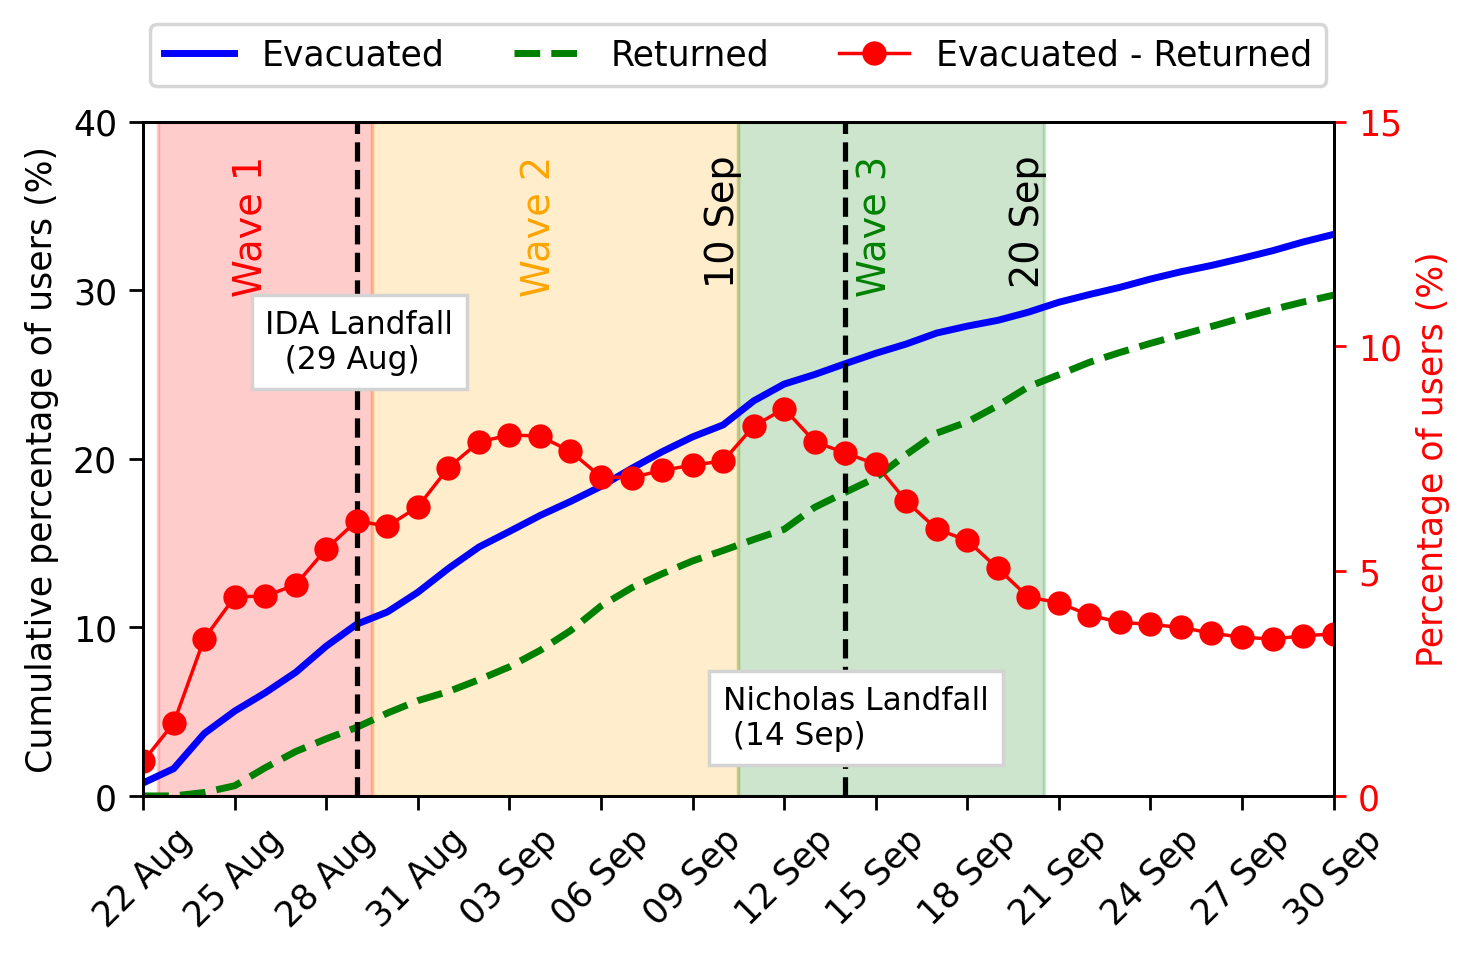

In [82]:
df = pd.DataFrame({x: merge_array(100 * merged_home_return_disp[x].cumsum() /
                         sample_size) for x in ['disp', 'return']})
df.index = pd.Index(pd.date_range('2021-08-22', '2021-11-30'), name='date')
fig, ax = plt.subplots(figsize=(6, 4), dpi=250)
plt.ylabel('Cumulative percentage of users (%)')

lns1 = ax.plot(df.index, df['disp'],'-', label='Evacuated', lw=2, color='b')
lns2 = ax.plot(df.index, df['return'],'--', label='Returned', lw=2, color='g')
# ax.plot(df.index, (df['disp'] - df['return']).values, '-o', label='Evacuated - Returned', lw=1, color='r')

ax2 = ax.twinx()
lns3 = ax2.plot(df.index, df['disp'] - df['return'], '-o', label='Evacuated - Returned', lw=1, color='r')
ax2.set_ylabel('Percentage of users (%)', color='r')

ymax = ax.get_ylim()[1]
colors = ['r', 'orange','g']
for w, start, end, color in [(1, '2021-08-22', '2021-08-29', 'r'),
                             (2, '2021-08-29', '2021-09-10', 'orange'),
                             (3, '2021-09-10', '2021-09-20', 'g')]:
    # shift the the start and end by half a day
    start2 = dt.datetime.fromisoformat(start) + dt.timedelta(hours=12)
    end2 = dt.datetime.fromisoformat(end) + dt.timedelta(hours=12)
    ax.axvspan(start2, end2, color=color, alpha=0.2)
    start, end = [dt.datetime.fromisoformat(x) for x in [start, end]]
    if w == 3:
        ax.text(start + (end - start) / 2, 0.75 * ymax, f'Wave {w}',
            fontsize=11, rotation=90, ha='center', va = 'top', color = colors[w-1])
    else:
        ax.text(start + (end - start) / 2, 0.75 * ymax, f'Wave {w}',
            fontsize=11, rotation=90, ha='center', va = 'top', color = colors[w-1])
ax.axvline(dt.date(2021, 8, 29), color='k', lw=1.5, ls='--')
kw = dict(fontsize=11, rotation=90, ha='center', va = 'top')
kw2 = dict(fontsize=9, ha='left', va = 'top')
ax.text(dt.date(2021, 8, 26), 0.57 * ymax, 'IDA Landfall\n  (29 Aug)',
        bbox=dict(facecolor='w', edgecolor='lightgrey', alpha=1), **kw2)

ax.axvline(dt.date(2021, 9, 14), color='k', lw=1.5, ls='--')
ax.text(dt.date(2021, 9, 10), 0.13 * ymax, 'Nicholas Landfall\n (14 Sep)',
        bbox=dict(facecolor='w', edgecolor='lightgrey', alpha=1), **kw2)

ax.text(dt.date(2021, 9, 10), 0.75 * ymax, '10 Sep', **kw)
ax.text(dt.date(2021, 9, 20), 0.75 * ymax, '20 Sep', **kw)
xticks = pd.date_range('2021-08-22', '2021-11-30', freq='3D')
ax.set_xticks(xticks, labels=xticks.strftime('%d %b'), rotation=45)
ax.set_xlim(xticks[0], xticks[-21])
ax.tick_params(which='major', left=True, bottom=True, size=4)
# ax.tick_params(which='minor', bottom=True, size=3)
# ax.xaxis.set_minor_locator(mpl.dates.DayLocator(1))
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]

ax.legend(lns, labs, loc='upper center', ncols = 3, bbox_to_anchor=(.5,1.17))
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30, 40])

# set tick color in red
ax2.tick_params(axis='y', colors='r')
ax2.set_ylim([0, 15])
ax2.set_yticks([0, 5, 10, 15])

plt.tight_layout()

plt.savefig('../figs/displacement.pdf')
plt.savefig('../figs/displacement.png', dpi=300)

Spatial distribution

In [83]:
pre_homes = pd.read_parquet(P.data + '/Ida_home.parquet')
merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg')

pre_homes = gpd.GeoDataFrame(pre_homes, geometry=gpd.points_from_xy(pre_homes['lon'], pre_homes['lat']), crs=CRS_DEG)

# Perform spatial join with 'within' predicate
pre_homes  = gpd.sjoin(pre_homes, merged_tract[['id', 'geometry']], how='inner', predicate='within')

In [84]:
merged_home = pd.read_parquet(P.data + "/disp_by_uid.parquet")

merged_home['disp_wave1'] = (merged_home['disp_t']>=22*2) & (merged_home['disp_t']<29*2)
merged_home['disp_wave2'] = (merged_home['disp_t']>=29*2) & (merged_home['disp_t']<40*2) # wave2
merged_home['disp_wave3'] = (merged_home['disp_t']>=40*2) & (merged_home['disp_t']<50*2) # wave3

merged_home['return_wave1'] = merged_home['disp_wave1']&(merged_home['returned_t']<(29+7)*2)
merged_home['return_wave2'] = merged_home['disp_wave2']&(merged_home['returned_t']<(40+7)*2)
merged_home['return_wave3'] = merged_home['disp_wave3']&(merged_home['returned_t']<(50+7)*2)

merged_home['return_wave1_'] = merged_home['disp_wave1']&(merged_home['returned_t']>=22*2)
merged_home['return_wave2_'] = merged_home['disp_wave2']&(merged_home['returned_t']>=29*2)
merged_home['return_wave3_'] = merged_home['disp_wave3']&(merged_home['returned_t']>=40*2)

merged_home['disp_wave0'] = merged_home['disp_wave1'] | merged_home['disp_wave2'] | merged_home['disp_wave3']
merged_home['return_wave0'] = merged_home['return_wave1'] | merged_home['return_wave2'] | merged_home['return_wave3']
merged_home['return_wave0_'] = merged_home['return_wave1_'] | merged_home['return_wave2_'] | merged_home['return_wave3_']


merged_home = pd.merge(merged_home, pre_homes[['uid', 'id']], left_on='uid', right_on='uid', how='left')

merged_home_agg = merged_home.groupby("id").agg({"disp_wave0":np.nansum, "disp_wave1":np.nansum, "disp_wave2":np.nansum, "disp_wave3":np.nansum,\
                                                     "return_wave0": np.nansum, "return_wave1": np.nansum, "return_wave2": np.nansum, "return_wave3": np.nansum, \
                                                         "return_wave0_": np.nansum, "return_wave1_": np.nansum, "return_wave2_": np.nansum, "return_wave3_": np.nansum, "uid":len}).reset_index()


merged_tract_ = pd.read_parquet(P.data + '/repres_by_merged_tract.parquet')

# Perform the merge
merged_home_agg = pd.merge(merged_tract_, merged_home_agg[['id', 'disp_wave0', 'disp_wave1', 'disp_wave2', 'disp_wave3',\
                                                            'return_wave0', 'return_wave1', 'return_wave2', 'return_wave3',\
                                                                  'return_wave0_', 'return_wave1_', 'return_wave2_', 'return_wave3_', 'uid']], left_on='id', right_on='id', how='left')

merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg')

merged_home_agg = pd.merge(merged_tract, merged_home_agg, on = 'id')

C:\Users\ALei\AppData\Local\Temp\ipykernel_5828\553769720.py:22: FutureWarning: The provided callable <function nansum at 0x0000017FFEF7E3B0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  merged_home_agg = merged_home.groupby("id").agg({"disp_wave0":np.nansum, "disp_wave1":np.nansum, "disp_wave2":np.nansum, "disp_wave3":np.nansum,\


In [85]:
merged_home_agg['ratio_wave0'] = (100*merged_home_agg['disp_wave0']/merged_home_agg['uid']).astype("float")
merged_home_agg['ratio_wave1'] = (100*merged_home_agg['disp_wave1']/merged_home_agg['uid']).astype("float")
merged_home_agg['ratio_wave2'] = (100*merged_home_agg['disp_wave2']/merged_home_agg['uid']).astype("float")
merged_home_agg['ratio_wave3'] = (100*merged_home_agg['disp_wave3']/merged_home_agg['uid']).astype("float")

In [86]:
storm_line = gpd.read_file(P.data + '/hurricane/ida_path/line').to_crs(CRS_M)
storm_pts = gpd.read_file(P.data + '/hurricane/ida_path/points').to_crs(CRS_M)

xmin, ymin, xmax, ymax = merged_home_agg.to_crs(CRS_M).total_bounds

c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Total evacuation rate: 27.44%


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Total evacuation rate: 9.42%


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Total evacuation rate: 11.11%


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Total evacuation rate: 6.91%


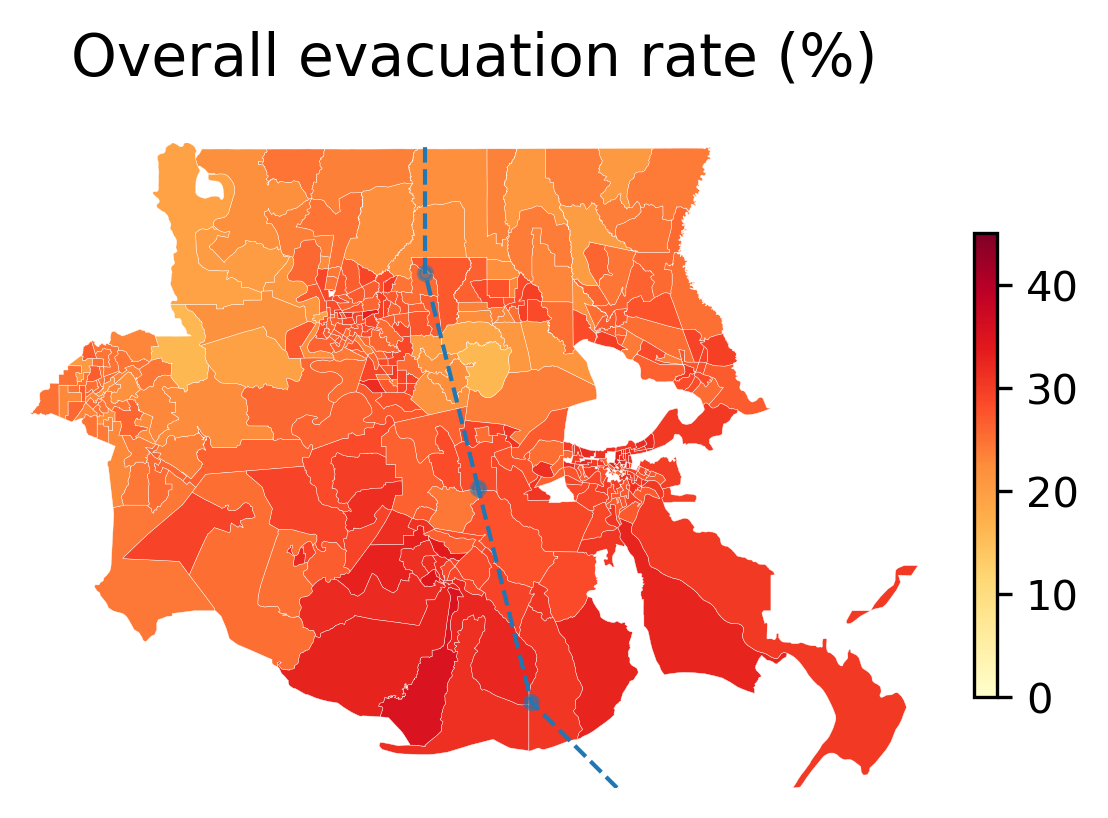

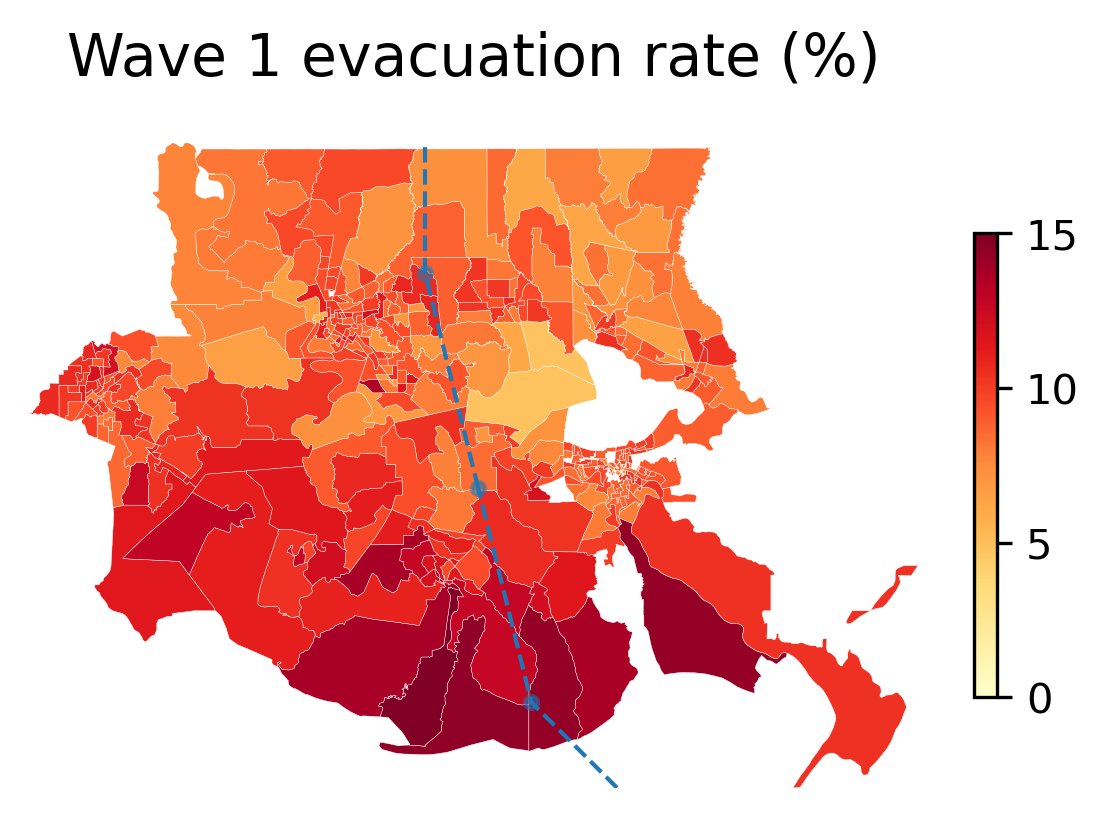

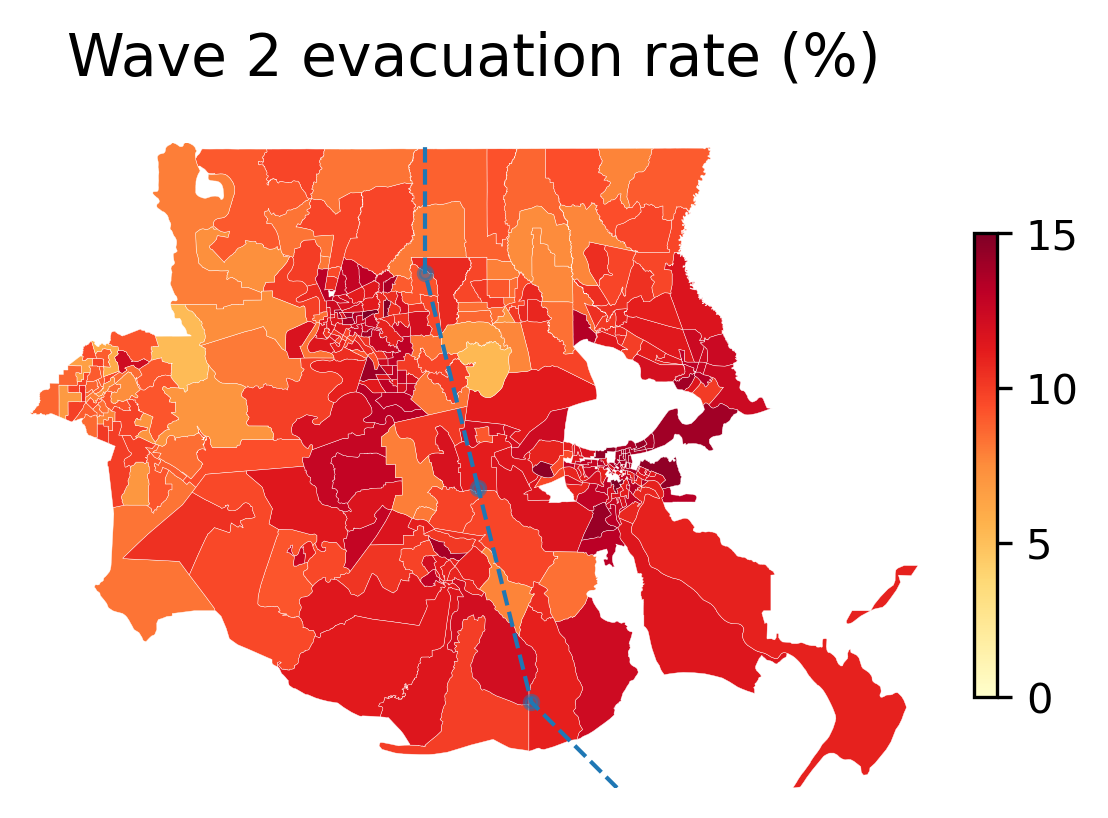

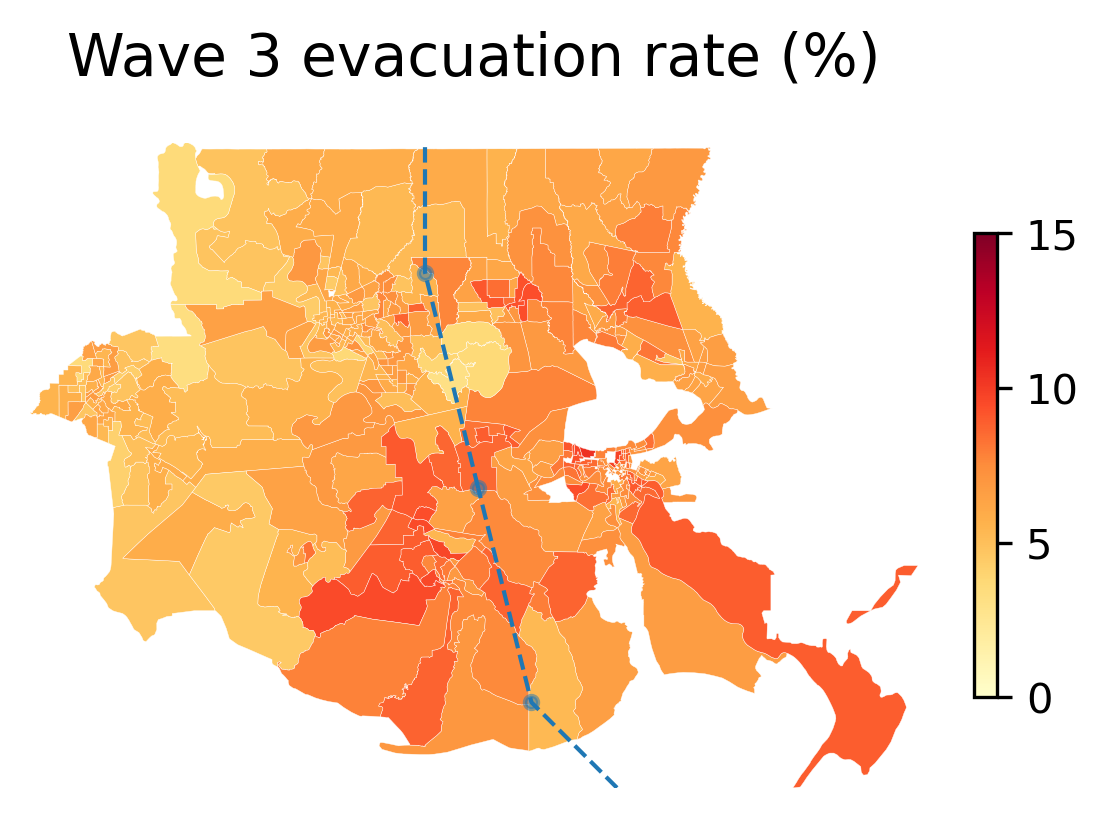

In [87]:
vmaxs = [45, 15, 15, 15]

for i in range(0,4):
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    plt.axis("off")
    # plt.title(f'Wave{i} evacuated users (%)')
    if i == 0:
        merged_home_agg.to_crs(CRS_M).plot(
            ax=ax, column=f'ratio_wave0', cmap='YlOrRd', legend=True, 
            vmin=0, vmax = vmaxs[i], linewidth=0.1, edgecolor='white',
            legend_kwds={'shrink':0.6})#, 'label':'Percentage of users (%)'})
    else:
        merged_home_agg.to_crs(CRS_M).plot(
        ax=ax, column=f'ratio_wave{i}', cmap='YlOrRd', legend=True, 
        vmin=0, vmax = vmaxs[i], linewidth=0.1, edgecolor='white',
        legend_kwds={'shrink':0.6})#, 'label':'Percentage of users (%)'})

    storm_line.plot(ax=ax, ls = '--', color='C0', linewidth=1)
    storm_pts.plot(ax=ax, markersize=10, color='C0', alpha=0.5)

    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    # if i == 0:
    # ax.text(x = 0.7*(xmax-xmin) + xmin, y = 0.8*(ymax-ymin) + ymin, s = f"Total evacuation\nrate: {100*np.sum(merged_home_agg[f'disp_wave{i}'])/np.sum(merged_home_agg[f'uid']):.2f}%")
    # else:
    #     ax.text(x = 0.7*(xmax-xmin) + xmin, y = 0.8*(ymax-ymin) + ymin, s = f"Wave{i} evacuation\nrate: {100*np.sum(merged_home_agg[f'disp_wave{i}'])/np.sum(merged_home_agg[f'uid']):.2f}%") # show evacuation rate in the plot
    
    print(f"Total evacuation rate: {100*np.sum(merged_home_agg[f'disp_wave{i}'])/np.sum(merged_home_agg[f'uid']):.2f}%")
    if i == 0:
        plt.title(f'Overall evacuation rate (%)', fontsize = 14)
    else:
        plt.title(f'Wave {i} evacuation rate (%)', fontsize = 14)
    plt.tight_layout()

    plt.savefig(f'../figs/wave{i}_displaced.pdf')
    plt.savefig(f'../figs/wave{i}_displaced.png', dpi=300)

In [88]:
merged_home_agg['ratio_wave0'] = (100*merged_home_agg['return_wave0']/merged_home_agg['disp_wave0']).astype("float")
merged_home_agg['ratio_wave1'] = (100*merged_home_agg['return_wave1']/merged_home_agg['disp_wave1']).astype("float")
merged_home_agg['ratio_wave2'] = (100*merged_home_agg['return_wave2']/merged_home_agg['disp_wave2']).astype("float")
merged_home_agg['ratio_wave3'] = (100*merged_home_agg['return_wave3']/merged_home_agg['disp_wave3']).astype("float")

c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Return within 7 days: 80.63%
Total return rate: 97.36%


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Return within 7 days: 71.25%
Total return rate: 97.92%


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Return within 7 days: 80.84%
Total return rate: 97.49%


c:\Users\ALei\anaconda3\envs\gp310\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Return within 7 days: 93.10%
Total return rate: 96.39%


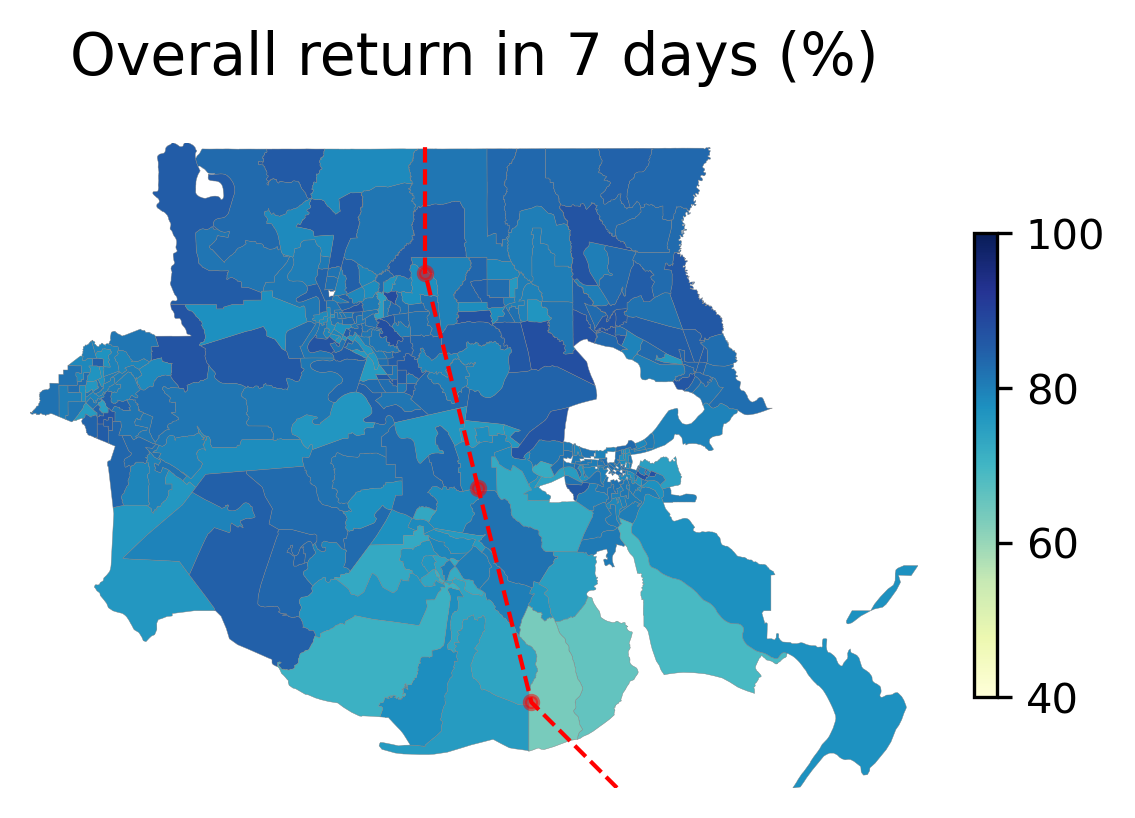

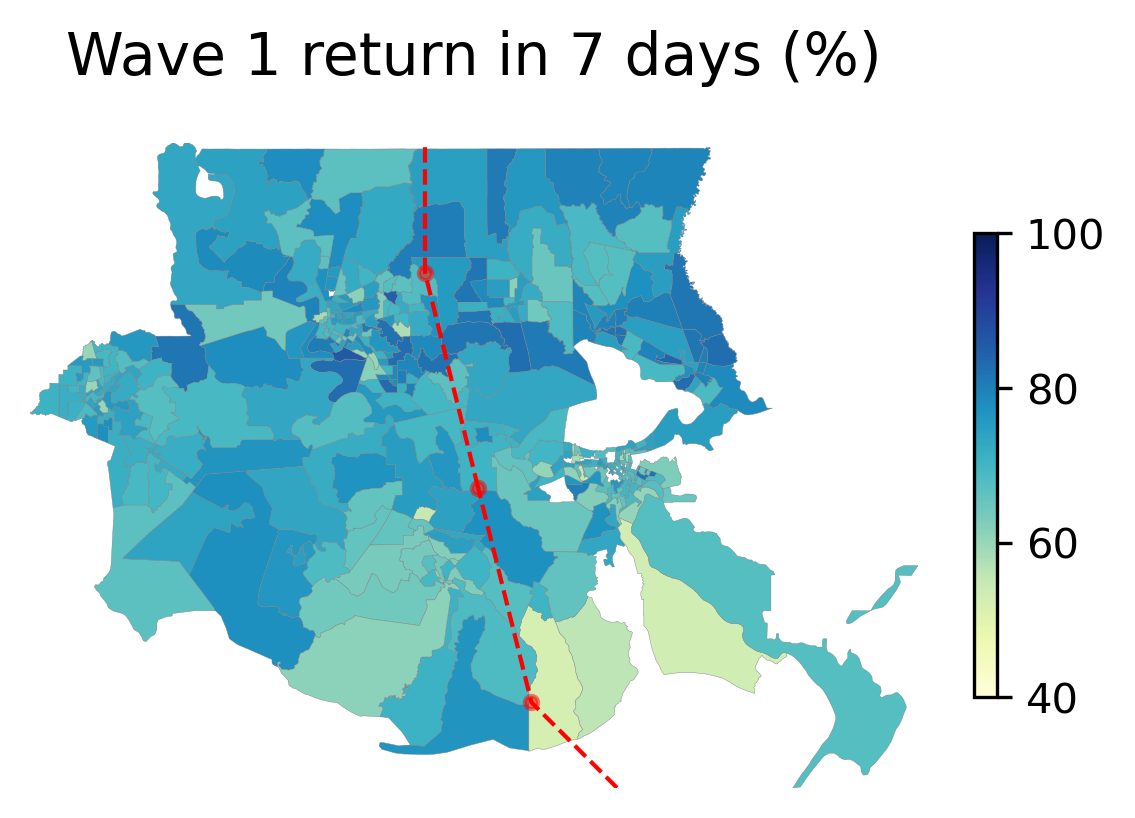

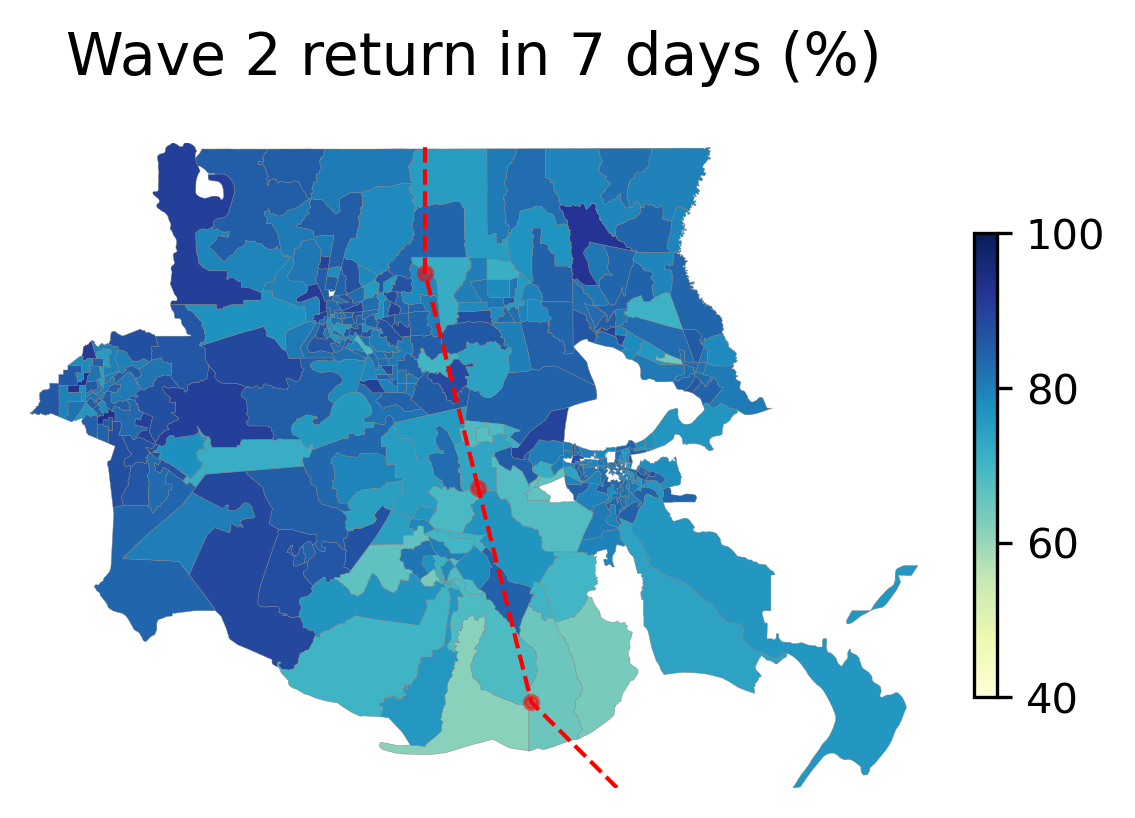

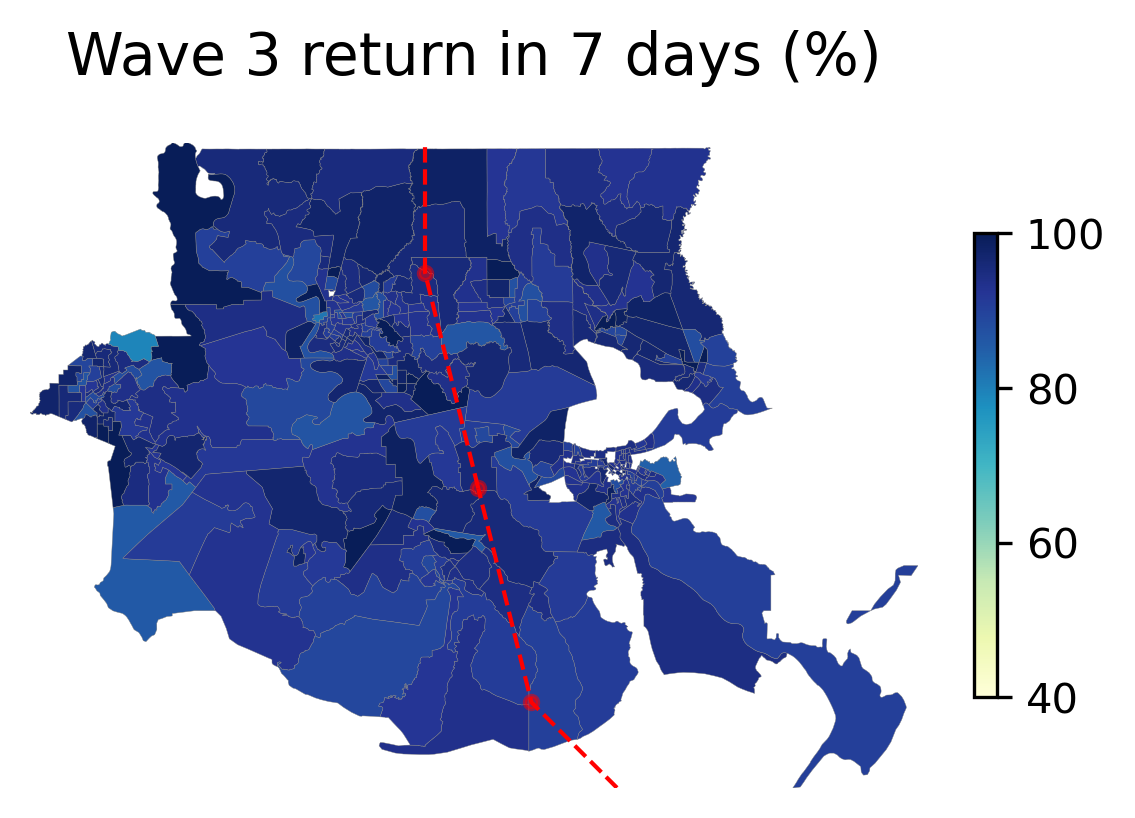

In [89]:
for i in range(0,4):
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    plt.axis("off")
    # plt.title(f'Wave{i} returned users within 7 days(%)')
    if i == 0:
        merged_home_agg.to_crs(CRS_M).plot(
            ax=ax, column=f'ratio_wave0', cmap='YlGnBu', legend=True, 
            vmin=40, vmax = 100, linewidth=0.1, edgecolor='grey',
            legend_kwds={'shrink':0.6})#, 'label':'Returned users (%)'})
    else:
        merged_home_agg.to_crs(CRS_M).plot(
        ax=ax, column=f'ratio_wave{i}', cmap='YlGnBu', legend=True, 
        vmin=40, vmax = 100, linewidth=0.1, edgecolor='grey',
        legend_kwds={'shrink':0.6})#, 'label':'Returned users (%)'})

    storm_line.plot(ax=ax, ls = '--', color='r', linewidth=1)
    storm_pts.plot(ax=ax, markersize=10, color='r', alpha=0.5)

    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    if i == 0:
        plt.title(f'Overall return in 7 days (%)', fontsize = 14)
    else:
        plt.title(f'Wave {i} return in 7 days (%)', fontsize = 14)

    # ax.text(x = 0.8*(xmax-xmin) + xmin, y = 0.7*(ymax-ymin) + ymin, s = f"Return within\n7 days: {100*np.sum(merged_home_agg[f'return_wave{i}'])/np.sum(merged_home_agg[f'disp_wave{i}']):.2f}%\n\nTotal return\nrate: {100*np.sum(merged_home_agg[f'return_wave{i}_'])/np.sum(merged_home_agg[f'disp_wave{i}']):.2f}%") # show evacuation rate in the plot
    print(f"Return within 7 days: {100*np.sum(merged_home_agg[f'return_wave{i}'])/np.sum(merged_home_agg[f'disp_wave{i}']):.2f}%")
    print(f"Total return rate: {100*np.sum(merged_home_agg[f'return_wave{i}_'])/np.sum(merged_home_agg[f'disp_wave{i}']):.2f}%")
    plt.tight_layout()
    plt.savefig(f'../figs/wave{i}_returned.pdf')
    plt.savefig(f'../figs/wave{i}_returned.png', dpi=300)

In [90]:
merged_home_agg['disp_ratio_wave0'] = (100*merged_home_agg['disp_wave0']/merged_home_agg['uid'].replace({ 0 : np.nan })).astype("float")
merged_home_agg['disp_ratio_wave1'] = (100*merged_home_agg['disp_wave1']/merged_home_agg['uid'].replace({ 0 : np.nan })).astype("float")
merged_home_agg['disp_ratio_wave2'] = (100*merged_home_agg['disp_wave2']/merged_home_agg['uid'].replace({ 0 : np.nan })).astype("float")
merged_home_agg['disp_ratio_wave3'] = (100*merged_home_agg['disp_wave3']/merged_home_agg['uid'].replace({ 0 : np.nan })).astype("float")

merged_home_agg['return_ratio_wave0_7days'] = (100*merged_home_agg['return_wave0']/merged_home_agg['disp_wave0'].replace({ 0 : np.nan })).astype("float")
merged_home_agg['return_ratio_wave1_7days'] = (100*merged_home_agg['return_wave1']/merged_home_agg['disp_wave1'].replace({ 0 : np.nan })).astype("float")
merged_home_agg['return_ratio_wave2_7days'] = (100*merged_home_agg['return_wave2']/merged_home_agg['disp_wave2'].replace({ 0 : np.nan })).astype("float")
merged_home_agg['return_ratio_wave3_7days'] = (100*merged_home_agg['return_wave3']/merged_home_agg['disp_wave3'].replace({ 0 : np.nan })).astype("float")

merged_home_agg['return_ratio_wave0'] = (100*merged_home_agg['return_wave0_']/merged_home_agg['disp_wave0'].replace({ 0 : np.nan })).astype("float")
merged_home_agg['return_ratio_wave1'] = (100*merged_home_agg['return_wave1_']/merged_home_agg['disp_wave1'].replace({ 0 : np.nan })).astype("float")
merged_home_agg['return_ratio_wave2'] = (100*merged_home_agg['return_wave2_']/merged_home_agg['disp_wave2'].replace({ 0 : np.nan })).astype("float")
merged_home_agg['return_ratio_wave3'] = (100*merged_home_agg['return_wave3_']/merged_home_agg['disp_wave3'].replace({ 0 : np.nan })).astype("float")

In [91]:
to_save = merged_home_agg[['id',  'disp_ratio_wave0', 'disp_ratio_wave1', 'disp_ratio_wave2', 'disp_ratio_wave3', \
                           'return_ratio_wave0', 'return_ratio_wave1', 'return_ratio_wave2', 'return_ratio_wave3',\
                            'return_ratio_wave0_7days', 'return_ratio_wave1_7days', 'return_ratio_wave2_7days', 'return_ratio_wave3_7days']]

In [92]:
# to_save.to_parquet(P.data+"/disp_by_county.parquet")
to_save.to_parquet(P.data+"/disp_by_merged_tract.parquet")